##  **ASSIGNMENT 2: Semantic Segmentation**
### Francesco Simonetti


In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from ctypes import resize
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

### **1. Loading and Preprocessing Images and Masks** ###

In this code, we load images and their corresponding masks for training a segmentation model.<br><br> 
**Rescaling and Loading Images and Masks** <br>
The images and masks are loaded from their respective folders and resized to the desired dimensions of 128x128 pixels. This ensures that all images have the same dimensions and are compatible with the model.

<br> **Data Splitting** <br>
The data is split into training and validation sets using the train_test_split function from the sklearn.model_selection module. In this case, 33% of the images will be used as the validation set, while the remaining 67% will be used for training the model.

<br> **Test Images** <br>
Some images have been removed from the dataset and placed in the "test_data" folder. These images will be used to evaluate the model's performance after training on the training and validation sets.





In [10]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3  # RGB

# image and mask for training path 
data_folder = "../training_data"
images_folder = os.path.join(data_folder, "horses")
masks_folder = os.path.join(data_folder, "masks")

train_ids = os.listdir(images_folder)

# array of images and maskssss
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i, image_name in enumerate(train_ids):
    # read the image
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path)
    # scale to desired size
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    # save the sclaed image 
    X[i] = image
    
    # Read the corresponding mask
    mask_path = os.path.join(masks_folder, image_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # scale to desired size
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    # add 1 dimenction at the mask
    mask = np.expand_dims(mask, axis=-1)
    # save the sclaed mask 
    y[i] = mask

# Now X contain images and y contain the corresponding masks, both scaled 

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  

### **2. U-Net architecture** ###

The architecture is based on U-Net, a convolutional neural network used for tasks such as image segmentation. It consists of an encoder and a decoder, with skip connections between corresponding layers of the encoder and decoder to transfer detailed information during reconstruction. The model's structure is based on the U-Net structure presented in the following article link [link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8604041) where the following architecture is shown:

<br>
The structure of the cited U-Net has been maintained, but with a reduction in the number of filters in both the encoder and decoder blocks to reduce the computational cost during training, as the model still retains the ability to capture relevant features.<br><br>

**Encoder**<br>
The encoder consists of a series of convolutional blocks followed by max-pooling layers. Each convolutional block includes two convolutional layers, enhancing the model's ability to extract features.<br>
**1) Convolutional Blocks (conv_block)**: Each conv_block applies two 2D convolutional layers with a specified number of filters, kernel size (3, 3), ReLU activation, and padding set to 'same'. The conv_block captures complex patterns and features within the input data.<br>
**2) Max-Pooling Layers:** after each conv_block, a MaxPooling2D layer with a pool size of (2, 2) reduces the spatial dimensions by half. This downsampling process helps the network to focus on more global features and reduces computational load by decreasing the resolution of the feature maps.<br>
**3) Outputs:** The encoder returns the bottleneck features c5 and a list of feature maps [c1, c2, c3, c4] from each layer before pooling. These feature maps are used in the decoder via skip connections to combine high-resolution and high-level features, which is crucial for precise segmentation. <br><br>

**Decoder**<br>
The decoder combines upsampled features with corresponding high-resolution features from the encoder via skip connections, allowing for precise localization and segmentation.<br>
**1) Transposed Convolution Layers (Conv2DTranspose):** layers perform upsampling by applying transposed convolutions, increasing the spatial dimensions of the feature maps. The transposed convolutions reverse the downsampling done by max-pooling in the encoder, gradually reconstructing the image size.<br>
**2) Concatenation Layers (concatenate):** layers concatenate the upsampled features with the corresponding high-resolution features from the encoder. The skip connections ensure that the decoder has access to both high-level abstract features and fine-grained details, improving the accuracy of the segmentation.<br>
**3) Convolutional Blocks (conv_block):** these blocks consist of two convolutional layers with ReLU activation and padding. The conv_block further processes the concatenated features, refining the feature maps after each upsampling step.


In [11]:
import tensorflow as tf

# input definition
inputs = tf.keras.layers.Input(shape=(None, None, 3))

# convolutional block
def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv


def encoder(inputs):
    c1 = conv_block(inputs, 16)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 256)
    return c5, [c1, c2, c3, c4]


def decoder(inputs, encoder_output):
    c5, skips = encoder_output

    u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat1 = tf.keras.layers.concatenate([u1, skips[3]], axis=3)
    c6 = conv_block(concat1, 128)

    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    concat2 = tf.keras.layers.concatenate([u2, skips[2]], axis=3)
    c7 = conv_block(concat2, 32)

    u3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    concat3 = tf.keras.layers.concatenate([u3, skips[1]], axis=3)
    c8 = conv_block(concat3, 32)

    u4 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    concat4 = tf.keras.layers.concatenate([u4, skips[0]], axis=3)
    c9 = conv_block(concat4, 16)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    return outputs





### **3. Training** ###

**Binary crossentropy**<br>
This metric is used as the loss function because, since the mask is a binary pixel image, the error between the predicted output and the target can be calculated as the difference between matching pixels relative to all pixels.<br>

**Callbacks**<br>
Two callbacks are defined to be used during model training:<br>

**EarlyStopping:** <br>
It halts the training if the validation loss (val_loss) does not improve for 15 consecutive epochs, aiding in preventing overfitting. <br>

**TensorBoard:** <br>
It records training data for visualization using TensorBoard, a tool for monitoring and visualizing model training. <br>

**Epochs:** <br>
The number of epochs was set to 100 because after several tests, I noticed that the training is stopped around the 80th epoch due to early stopping.


In [12]:
encoder_output = encoder(inputs)

outputs = decoder(inputs, encoder_output)

# model creation 
model = tf.keras.models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# training of the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=100, callbacks=callbacks)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4846 - loss: 3.7080 - val_accuracy: 0.7814 - val_loss: 0.5235
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7694 - loss: 0.5371 - val_accuracy: 0.8081 - val_loss: 0.4380
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7978 - loss: 0.4618 - val_accuracy: 0.8261 - val_loss: 0.4021
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8116 - loss: 0.4232 - val_accuracy: 0.8551 - val_loss: 0.3549
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8534 - loss: 0.3637 - val_accuracy: 0.8872 - val_loss: 0.2851
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8695 - loss: 0.3251 - val_accuracy: 0.8882 - val_loss: 0.2848
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8943 - loss: 0.2714 - val_accuracy: 0.8957 - val_loss: 0.2698
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8911 - loss: 0.2748 - val_accuracy: 0.9007 - v

### **3.1 Training plot** ### 
This code displays the loss curves during model training. The red curve represents the training loss, while the blue dots indicate the validation loss at each epoch.

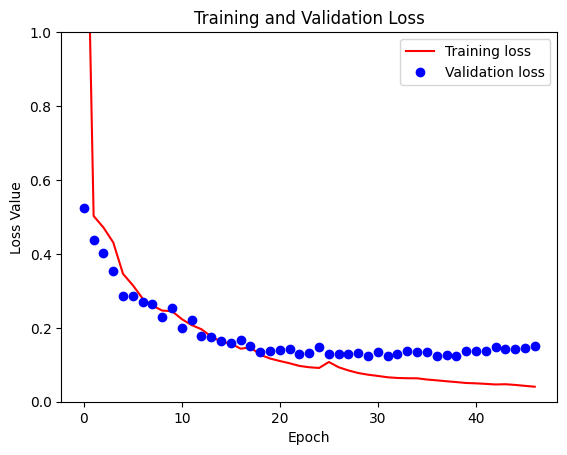

In [13]:
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### **5. TEST** ###

5.1 test 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


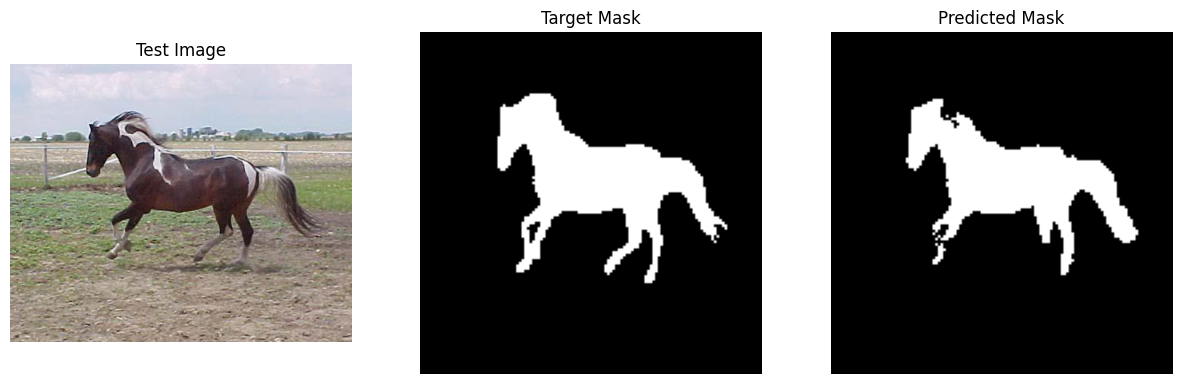

In [19]:
MG_HEIGHT = 128
IMG_WIDTH = 128
# 028 - 124 - 295
# DA TENERE 050 - 045 - 037 - 267 - 041 (pos) 

# test image
test_image_path = "../test_data/horses/horse162.png" # 218 283 315 273
test_image = np.array(Image.open(test_image_path)) 
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))
# mask
test_mask_path = "../test_data/masks/horse162.png" # 218 283 315 273
test_mask = np.array(Image.open(test_mask_path)) 
# predicted mask 
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
threshold = 0.5 
binary_predicted_mask = predicted_mask > threshold

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot image test
axes[0].imshow(test_image)
axes[0].set_title('Test Image')
axes[0].axis('off') 
# Plot mask target
test_mask_rescale = cv2.resize(test_mask, (IMG_WIDTH, IMG_HEIGHT))
axes[1].imshow(test_mask_rescale, cmap='gray')
axes[1].set_title('Target Mask')
axes[1].axis('off')
# Plot mask target
axes[2].imshow(binary_predicted_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')  # Rimuovi gli assi

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


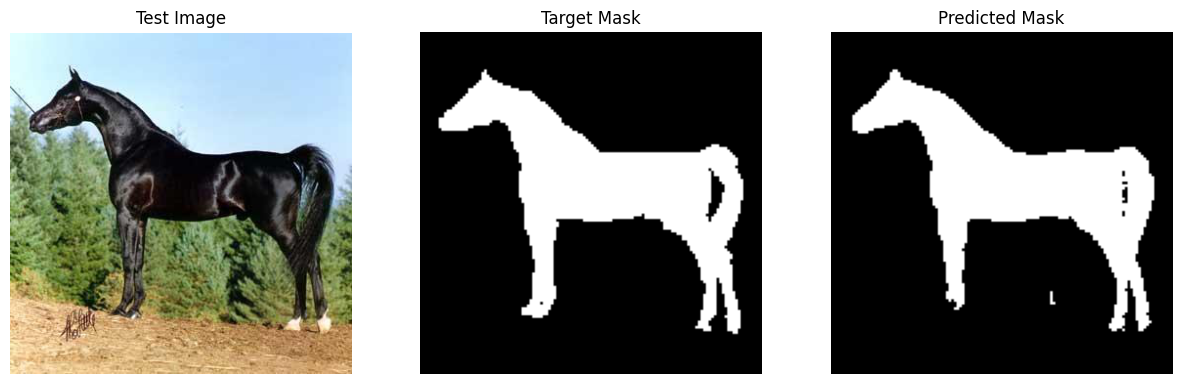

In [17]:
# test image
test_image_path = "../test_data/horses/horse315.png" # 218 283 315 273
test_image = np.array(Image.open(test_image_path)) 
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))
# mask
test_mask_path = "../test_data/masks/horse315.png" # 218 283 315 273
test_mask = np.array(Image.open(test_mask_path)) 
# predicted mask 
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
threshold = 0.5 
binary_predicted_mask = predicted_mask > threshold

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot image test
axes[0].imshow(test_image)
axes[0].set_title('Test Image')
axes[0].axis('off') 
# Plot mask target
test_mask_rescale = cv2.resize(test_mask, (IMG_WIDTH, IMG_HEIGHT))
axes[1].imshow(test_mask_rescale, cmap='gray')
axes[1].set_title('Target Mask')
axes[1].axis('off')
# Plot mask target
axes[2].imshow(binary_predicted_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')  # Rimuovi gli assi

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


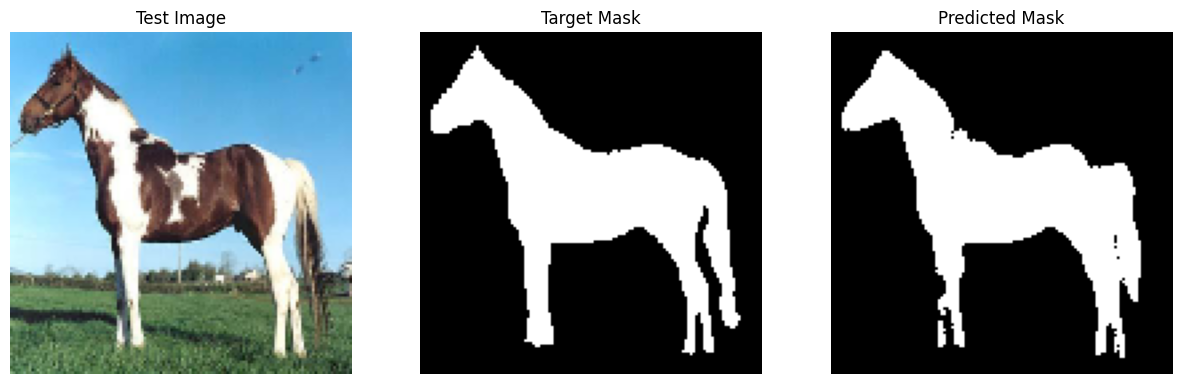

In [16]:
MG_HEIGHT = 128
IMG_WIDTH = 128

# test image
test_image_path = "../test_data/horses/horse069.png" # 218 283 
test_image = np.array(Image.open(test_image_path)) 
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))

# test mask
test_mask_path = "../test_data/masks/horse069.png" # 218 283 
test_mask = np.array(Image.open(test_mask_path)) 

# predicted mask
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
threshold = 0.5 
binary_mask = predicted_mask > threshold

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot image test
axes[0].imshow(rescaled_test_image)
axes[0].set_title('Test Image')
axes[0].axis('off') 
# Plot mask target
test_mask_rescale = cv2.resize(test_mask, (IMG_WIDTH, IMG_HEIGHT))
axes[1].imshow(test_mask_rescale, cmap='gray')
axes[1].set_title('Target Mask')
axes[1].axis('off')
# Plot mask target
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')  # Rimuovi gli assi

plt.show()

### **X. Test con altri modelli** ###
X.1 FNC 
Come primo modello ho deciso 